In [17]:
import os

import lucem_illud
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import sklearn
import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.neighbors
import sklearn.neural_network
import sklearn.tree
from IPython.display import display

%matplotlib inline

# Constants, Utility Functions, and Data Importing

In [3]:
# Constants
NOISE = 0.2
TEST_SPLIT = 0.2
NUM_PER_CATEGORY = 750

In [4]:
# Utility Functions
def pca_split_stats(
    test_df: pd.DataFrame,
    train_df: pd.DataFrame,
    red_pca_key: str,
    category_key: str = "category",
    dimensions: int = 10,
) -> None:
    logistic = sklearn.linear_model.LogisticRegression()
    train_df[red_pca_key] = train_df["pca"].apply(lambda x: x[:dimensions])
    test_df[red_pca_key] = test_df["pca"].apply(lambda x: x[:dimensions])

    logistic.fit(np.stack(train_df[red_pca_key], axis=0), train_df[category_key])

    print(f"Linear Regression stats for {dimensions} dimensions")
    print("Training:")
    print(
        logistic.score(np.stack(train_df[red_pca_key], axis=0), train_df[category_key])
    )
    print("Testing:")
    print(logistic.score(np.stack(test_df[red_pca_key], axis=0), test_df[category_key]))


def classifier_evaluation(
    train_df: pd.DataFrame, test_df: pd.DataFrame
) -> (pd.DataFrame, pd.DataFrame):
    classifiers = [
        (sklearn.naive_bayes.GaussianNB(), "Gaussian"),
        (sklearn.svm.SVC(kernel="linear", probability=True), "Linear SVC"),
        (
            sklearn.svm.SVC(kernel="poly", degree=3, probability=True),
            "Poly SVC",
        ),
        (
            sklearn.neighbors.KNeighborsClassifier(5, weights="distance"),
            "KNN",
        ),
        (sklearn.linear_model.LogisticRegression(), "Logistic Regression"),
        (sklearn.tree.DecisionTreeClassifier(), "Decision Tree"),
        (sklearn.ensemble.RandomForestClassifier(), "Random Forest"),
        (sklearn.neural_network.MLPClassifier(), "MLP"),
        (sklearn.ensemble.GradientBoostingClassifier(), "Gradient Boosting"),
    ]

    cm_df = pd.DataFrame(
        columns=["Classifier", "True Pos", "False Pos", "True Neg", "False Neg"]
    )

    eval_df = pd.DataFrame(
        columns=[
            "Classifier",
            "Positive",
            "Error_Rate",
            "AUC",
            "Precision",
            "Average_Precision",
            "Recall",
        ]
    )

    for clf, name in classifiers:
        clf.fit(np.stack(train_df["vect"], axis=0), train_df["category"])
        df = lucem_illud.evaluateClassifier(clf, test_df)
        df["Classifier"] = name
        df["Positive"] = [s == 1 for s in df.index]
        predictions = clf.predict(np.stack(test_df["vect"], axis=0))
        mat = sklearn.metrics.confusion_matrix(test_df["category"], predictions)
        cm_df = pd.concat(
            [
                cm_df,
                pd.DataFrame(
                    [
                        {
                            "Classifier": name,
                            "True Pos": mat[0][0],
                            "False Pos": mat[0][1],
                            "True Neg": mat[1][0],
                            "False Neg": mat[1][1],
                        }
                    ]
                ),
            ],
            ignore_index=True,
        )

        eval_df = pd.concat([eval_df, df], ignore_index=True)
        # The below images were not generated due to it making it unreadable.
        # lucem_illud.plotConfusionMatrix(clf, test_df)
        # lucem_illud.plotMultiROC(clf, test_df)
        # lucem_illud.plotregions(clf, train_df)
    return cm_df, eval_df


def logistic_regression_visualizer(df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    clf = sklearn.linear_model.LogisticRegression()
    clf.fit(np.stack(lg_test_df["vect"], axis=0), df["category"])
    eval_df = lucem_illud.evaluateClassifier(clf, df)
    eval_df["Positive"] = [s == 1 for s in eval_df.index]
    predictions = clf.predict(np.stack(df["vect"], axis=0))
    mat = sklearn.metrics.confusion_matrix(df["category"], predictions)
    cm_df = pd.concat(
        [
            pd.DataFrame(columns=["True Pos", "False Pos", "True Neg", "False Neg"]),
            pd.DataFrame(
                [
                    {
                        "True Pos": mat[0][0],
                        "False Pos": mat[0][1],
                        "True Neg": mat[1][0],
                        "False Neg": mat[1][1],
                    }
                ]
            ),
        ],
        ignore_index=True,
    )
    f_measure = mat[0][0] / (mat[0][0] + 0.5 * (mat[0][1] + mat[1][1]))
    print(f"F-measure: {f_measure}")

    eval_df = pd.concat(
        [
            pd.DataFrame(
                columns=[
                    "Positive",
                    "Error_Rate",
                    "AUC",
                    "Precision",
                    "Average_Precision",
                    "Recall",
                ]
            ),
            eval_df,
        ],
        ignore_index=True,
    )
    lucem_illud.plotConfusionMatrix(clf, df)

    return cm_df, eval_df

In [5]:
# Data is sourced from a personal project of mine you can find here:
# https://ucpd-incident-reporter-7cfdc3369124.herokuapp.com/
ucpd_feather_path = "data/fully_tokenized_ucpd_incidents.feather"
if os.path.isfile(ucpd_feather_path):
    ucpd_reports = pd.read_feather(ucpd_feather_path)
else:
    # WARNING: This step takes about 120 minutes, so don't run it unless you need to.
    ucpd_reports = pd.read_csv("data/incident_dump.csv")
    ucpd_reports["tokenized_text"] = ucpd_reports["comments"].apply(
        lucem_illud.word_tokenize
    )
    ucpd_reports["normalized_text"] = ucpd_reports["tokenized_text"].apply(
        lucem_illud.normalizeTokens
    )
    ucpd_reports.to_feather(ucpd_feather_path)
ucpd_reports.head(50)

,comments,disposition,incident,location,occurred,predicted_incident,reported,reported_date,ucpd_id,validated_address,validated_location,tokenized_text,normalized_text
0,A person was transported to Comer Hospital by ...,Closed,Mental Health Transport,6300 S. University Ave. (S. Woodlawn Ave. Char...,2/1/24 10:10 AM,None,2024-02-01T10:10:00-06:00,2024-02-01,24-00114,"6300 S UNIVERSITY AVE, CHICAGO, IL, 60637","41.78045407997166,-87.59732203570559","[A, person, was, transported, to, Comer, Hospi...","[person, transport, comer, hospital, cfd, ems,..."
1,Catalytic converter taken from a 2015 Toyota p...,Open,Theft from Motor Vehicle,1210 E. 57th St. (Public Way),1/31/24 to 2/1/24 6:00 PM to 7:00 AM,None,2024-02-01T10:18:00-06:00,2024-02-01,24-00115,"1210 E 57TH ST, CHICAGO, IL, 60637","41.79150658678615,-87.59602168542061","[Catalytic, converter, taken, from, a, 2015, T...","[catalytic, converter, take, toyota, park, str..."
2,Debit and credit cards taken from wallet in un...,Open,Theft,900 E. 57th St. (Knapp Center),2/1/24 9:50 AM to 4:30 PM,None,2024-02-01T17:54:00-06:00,2024-02-01,24-00116,"900 E 57TH ST, CHICAGO, IL, 60637","41.791423455510476,-87.60366291896175","[Debit, and, credit, cards, taken, from, walle...","[debit, credit, card, take, wallet, unattended..."
3,Boyfriend battered girlfriend in off-campus pr...,Open,Domestic Battery,6040 S. Harper Ave. (Apt. Building),2/1/24 2:45 PM,None,2024-02-01T15:45:00-06:00,2024-02-01,24-00117,"6040 S HARPER AVE, CHICAGO, IL, 60637","41.78472618578524,-87.58821677767634","[Boyfriend, battered, girlfriend, in, off, cam...","[boyfriend, batter, girlfriend, campus, privat..."
4,A known suspect entered the off-campus store a...,Referred,Information / Theft,1346 E. 53rd St. (Target),1/31/24 12:15 PM,None,2024-01-31T14:16:00-06:00,2024-01-31,2024-004118,"1346 E 53RD ST, CHICAGO, IL, 60615","41.79955044222366,-87.593062823983","[A, known, suspect, entered, the, off, campus,...","[know, suspect, enter, campus, store, take, me..."
5,Person found a social security card on the str...,Closed,Found Property,5800 S. Ellis Ave. (Public Way),1/31/24 12:10 PM,None,2024-01-31T12:10:00-06:00,2024-01-31,24-00113,"5800 S ELLIS AVE, CHICAGO, IL, 60637","41.78955246628657,-87.60133694890986","[Person, found, a, social, security, card, on,...","[person, find, social, security, card, street,..."
6,Window smashed and tools taken from van parked...,Referred,Information / Theft,1522 E. 59th St. (Public Way),1/30/24 8:00 AM to 9:15 AM,None,2024-01-30T09:35:00-06:00,2024-01-30,2024-003951,"1522 E 59TH ST, CHICAGO, IL, 60637","41.787940677385954,-87.5883629192693","[Window, smashed, and, tools, taken, from, van...","[window, smash, tool, take, van, park, street,..."
7,Unknown person(s) forced entry to victim's off...,CPD,Information / Burglary,S. Kenwood Ave. between E. 56th St. and E. 57t...,1/30/24 7:30 AM to 8:30 PM,None,2024-01-30T20:33:00-06:00,2024-01-30,2024-004004,"and South Kenwood Avenue, between, IL 60637","41.7912193,-87.6067356","[Unknown, person(s, forced, entry, to, victim,...","[unknown, person(s, force, entry, victim, camp..."
8,Unknown person attempted to enter victim's off...,CPD,Information / Attempted Burglary,S. Kimbark Ave. between E. 53rd St. and E. 54t...,1/30/24 8:15 PM,None,2024-01-30T20:46:00-06:00,2024-01-30,2024-004007,"between E. 53rd St. and, S. Kimbark Ave, Chica...","41.7980034,-87.5941627","[Unknown, person, attempted, to, enter, victim...","[unknown, person, attempt, enter, victim, camp..."
9,Victim walking in the crosswalk was struck by ...,Open,Traffic Crash / Hit and Run / Personal Injury,5500 S. Ingleside Ave. (Public Way),1/30/24 7:40 AM,None,2024-01-30T07:47:00-06:00,2024-01-30,24-00105,"5500 South Ingleside Avenue, Chicago, IL 60615...","41.7956509,-87.6030342","[Victim, walking, in, the, crosswalk, was, str...","[victim, walk, crosswalk, strike, unknown, veh..."


## <font color="red">*Exercise 1*</font>

<font color="red">Perform a content annotation survey of some kind in which at 
least 3 people evaluate and code each piece of content, using Amazon Mechanical 
Turk as described in the [MTurk slides on Canvas](https://canvas.uchicago.edu/courses/54694/files/folder/unfiled?preview=10675152), or by hand with friends.  
With the resulting data, calculate, visualize and discuss inter-coder agreement or 
co-variation with appropriate metrics. What does this means for the reliability of 
human assessments regarding content in your domain?

In [208]:
# Figure out a way to chunk up the data

## <font color="red">*Exercise 2*</font>

<font color="red">Go back through all the cells above and generate 10 distinct 
artificial datasets and classify them with all the available methods. Add a cell 
immediately below and describe which classifier(s) worked best with which 
artificially constructed data source and why. Then go through all the empirical 
datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify 
them with all available methods. Add a second cell immediately below and describe 
which classifier(s) worked best with which data set and why.

<font color="red">***Stretch*** (but also required) Wander through the SKLearn 
documentation available [here](http://scikit-learn.org/stable/), particularly 
perusing the classifiers. In cells following, identify and implement a new classifier 
that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real 
dataset (used above). Then, in the next cell describe the classifier, detail how it 
compares with the approaches above, and why it performed better or worse than others.

### Generated Datasets

In [216]:
# Dataset 1
ds1_cm, ds1_eval = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.random(), test_size=TEST_SPLIT
    )
)
display(ds1_cm, ds1_eval)

,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,44,59,39,58
1,Linear SVC,49,54,39,58
2,Poly SVC,46,57,38,59
3,KNN,57,46,44,53
4,Logistic Regression,47,56,30,67
5,Decision Tree,47,56,42,55
6,Random Forest,55,48,45,52
7,MLP,41,62,35,62
8,Gradient Boosting,52,51,55,42


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.490,0.512561,0.530120,0.521459,0.427184
1,Gaussian,True,0.490,0.512561,0.495726,0.491414,0.597938
2,Linear SVC,False,0.465,0.536833,0.556818,0.534894,0.475728
3,Linear SVC,True,0.465,0.536833,0.517857,0.504647,0.597938
4,Poly SVC,False,0.475,0.527425,0.547619,0.529568,0.446602
5,Poly SVC,True,0.475,0.527425,0.508621,0.499367,0.608247
6,KNN,False,0.450,0.549895,0.564356,0.542314,0.553398
7,KNN,True,0.450,0.549895,0.535354,0.512513,0.546392
8,Logistic Regression,False,0.430,0.573516,0.610390,0.558527,0.456311
9,Logistic Regression,True,0.430,0.573516,0.544715,0.526247,0.690722


In [218]:
# Dataset 2
ds2_cm, ds2_eval = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.andSplit(NOISE), test_size=TEST_SPLIT
    )
)
display(ds2_cm, ds2_eval)

,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,86,13,12,89
1,Linear SVC,86,13,13,88
2,Poly SVC,87,12,12,89
3,KNN,85,14,17,84
4,Logistic Regression,85,14,12,89
5,Decision Tree,82,17,14,87
6,Random Forest,81,18,14,87
7,MLP,84,15,12,89
8,Gradient Boosting,81,18,13,88


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.125,0.874937,0.877551,0.827317,0.868687
1,Gaussian,True,0.125,0.874937,0.872549,0.828880,0.881188
2,Linear SVC,False,0.130,0.869987,0.868687,0.819617,0.868687
3,Linear SVC,True,0.130,0.869987,0.871287,0.824141,0.871287
4,Poly SVC,False,0.120,0.879988,0.878788,0.832268,0.878788
5,Poly SVC,True,0.120,0.879988,0.881188,0.836493,0.881188
6,KNN,False,0.155,0.845135,0.833333,0.785488,0.858586
7,KNN,True,0.155,0.845135,0.857143,0.797871,0.831683
8,Logistic Regression,False,0.130,0.869887,0.876289,0.822369,0.858586
9,Logistic Regression,True,0.130,0.869887,0.864078,0.821415,0.881188


In [220]:
# Dataset 3
ds3_cm, ds3_eval = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.xorSplit(NOISE), test_size=TEST_SPLIT
    )
)
display(ds3_cm, ds3_eval)

/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,68,32,59,41
1,Linear SVC,59,41,53,47
2,Poly SVC,57,43,10,90
3,KNN,91,9,13,87
4,Logistic Regression,42,58,52,48
5,Decision Tree,91,9,11,89
6,Random Forest,96,4,8,92
7,MLP,94,6,7,93
8,Gradient Boosting,94,6,10,90


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.455,0.545,0.535433,0.524094,0.68
1,Gaussian,True,0.455,0.545,0.561644,0.525274,0.41
2,Linear SVC,False,0.470,0.530,0.526786,0.515804,0.59
3,Linear SVC,True,0.470,0.530,0.534091,0.516023,0.47
4,Poly SVC,False,0.265,0.735,0.850746,0.699925,0.57
5,Poly SVC,True,0.265,0.735,0.676692,0.659023,0.90
6,KNN,False,0.110,0.890,0.875000,0.841250,0.91
7,KNN,True,0.110,0.890,0.906250,0.853438,0.87
8,Logistic Regression,False,0.550,0.450,0.446809,0.477660,0.42
9,Logistic Regression,True,0.550,0.450,0.452830,0.477358,0.48


In [229]:
# Dataset 4
ds4_cm, ds4_eval = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.targetSplit(NOISE), test_size=TEST_SPLIT
    )
)
display(ds4_cm, ds4_eval)

/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,93,10,8,89
1,Linear SVC,93,10,58,39
2,Poly SVC,103,0,85,12
3,KNN,95,8,8,89
4,Logistic Regression,48,55,45,52
5,Decision Tree,91,12,12,85
6,Random Forest,95,8,11,86
7,MLP,96,7,12,85
8,Gradient Boosting,92,11,10,87


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.090,0.910219,0.920792,0.881395,0.902913
1,Gaussian,True,0.090,0.910219,0.898990,0.864846,0.917526
2,Linear SVC,False,0.340,0.652487,0.615894,0.606099,0.902913
3,Linear SVC,True,0.340,0.652487,0.795918,0.610008,0.402062
4,Poly SVC,False,0.425,0.561856,0.547872,0.547872,1.000000
5,Poly SVC,True,0.425,0.561856,1.000000,0.548711,0.123711
6,KNN,False,0.080,0.919928,0.922330,0.890693,0.922330
7,KNN,True,0.080,0.919928,0.917526,0.881854,0.917526
8,Logistic Regression,False,0.500,0.501051,0.516129,0.515526,0.466019
9,Logistic Regression,True,0.500,0.501051,0.485981,0.485526,0.536082


In [222]:
# Dataset 5
ds5_cm, ds5_eval = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.multiBlobs(NOISE), test_size=TEST_SPLIT
    )
)
display(ds5_cm, ds5_eval)

/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,94,0,0,105
1,Linear SVC,94,0,0,105
2,Poly SVC,94,0,0,105
3,KNN,94,0,0,105
4,Logistic Regression,94,0,0,105
5,Decision Tree,94,0,0,105
6,Random Forest,94,0,0,105
7,MLP,94,0,0,105
8,Gradient Boosting,94,0,0,105


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.000,1.000000,1.000000,1.000000,1.000000
1,Gaussian,True,0.002,0.998734,0.990566,0.990566,1.000000
2,Gaussian,False,0.000,1.000000,1.000000,1.000000,1.000000
3,Gaussian,False,0.044,0.934532,0.881188,0.812179,0.898990
4,Gaussian,False,0.042,0.926978,0.904255,0.816389,0.876289
5,Linear SVC,False,0.000,1.000000,1.000000,1.000000,1.000000
6,Linear SVC,True,0.002,0.998734,0.990566,0.990566,1.000000
7,Linear SVC,False,0.000,1.000000,1.000000,1.000000,1.000000
8,Linear SVC,False,0.044,0.930729,0.888889,0.812123,0.888889
9,Linear SVC,False,0.042,0.930892,0.895833,0.816244,0.886598


In [223]:
# Dataset 6
ds6_cm, ds6_eval = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.random(NUM_PER_CATEGORY), test_size=TEST_SPLIT
    )
)
display(ds6_cm, ds6_eval)

,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,91,51,106,52
1,Linear SVC,67,75,80,78
2,Poly SVC,92,50,104,54
3,KNN,62,80,81,77
4,Logistic Regression,88,54,102,56
5,Decision Tree,67,75,80,78
6,Random Forest,64,78,89,69
7,MLP,59,83,77,81
8,Gradient Boosting,65,77,93,65


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.523333,0.484979,0.461929,0.466025,0.640845
1,Gaussian,True,0.523333,0.484979,0.504854,0.519488,0.329114
2,Linear SVC,False,0.516667,0.482751,0.455782,0.465052,0.471831
3,Linear SVC,True,0.516667,0.482751,0.509804,0.518342,0.493671
4,Poly SVC,False,0.513333,0.494830,0.469388,0.470777,0.647887
5,Poly SVC,True,0.513333,0.494830,0.519231,0.524125,0.341772
6,KNN,False,0.536667,0.461981,0.433566,0.455970,0.436620
7,KNN,True,0.536667,0.461981,0.490446,0.509015,0.487342
8,Logistic Regression,False,0.520000,0.487074,0.463158,0.467027,0.619718
9,Logistic Regression,True,0.520000,0.487074,0.509091,0.520437,0.354430


In [224]:
# Dataset 7
ds7_cm, ds7_eval = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.andSplit(NOISE, NUM_PER_CATEGORY), test_size=TEST_SPLIT
    )
)
display(ds7_cm, ds7_eval)

,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,124,17,14,145
1,Linear SVC,124,17,15,144
2,Poly SVC,121,20,15,144
3,KNN,123,18,22,137
4,Logistic Regression,124,17,15,144
5,Decision Tree,124,17,24,135
6,Random Forest,123,18,20,139
7,MLP,123,18,14,145
8,Gradient Boosting,121,20,17,142


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.103333,0.895691,0.898551,0.846881,0.879433
1,Gaussian,True,0.103333,0.895691,0.895062,0.862918,0.911950
2,Linear SVC,False,0.106667,0.892547,0.892086,0.841196,0.879433
3,Linear SVC,True,0.106667,0.892547,0.894410,0.860032,0.905660
4,Poly SVC,False,0.116667,0.881908,0.889706,0.830173,0.858156
5,Poly SVC,True,0.116667,0.881908,0.878049,0.845214,0.905660
6,KNN,False,0.133333,0.866988,0.848276,0.799985,0.872340
7,KNN,True,0.133333,0.866988,0.883871,0.834908,0.861635
8,Logistic Regression,False,0.106667,0.892547,0.892086,0.841196,0.879433
9,Logistic Regression,True,0.106667,0.892547,0.894410,0.860032,0.905660


In [225]:
# Dataset 8
ds8_cm, ds8_eval = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.xorSplit(NOISE, NUM_PER_CATEGORY), test_size=TEST_SPLIT
    )
)
display(ds8_cm, ds8_eval)

/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,69,86,70,75
1,Linear SVC,62,93,28,117
2,Poly SVC,74,81,11,134
3,KNN,136,19,20,125
4,Logistic Regression,69,86,66,79
5,Decision Tree,133,22,23,122
6,Random Forest,136,19,26,119
7,MLP,139,16,24,121
8,Gradient Boosting,138,17,21,124


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.520000,0.481201,0.496403,0.507646,0.445161
1,Gaussian,True,0.520000,0.481201,0.465839,0.474284,0.517241
2,Linear SVC,False,0.403333,0.603448,0.688889,0.585556,0.400000
3,Linear SVC,True,0.403333,0.603448,0.557143,0.542890,0.806897
4,Poly SVC,False,0.306667,0.700779,0.870588,0.685636,0.477419
5,Poly SVC,True,0.306667,0.700779,0.623256,0.612641,0.924138
6,KNN,False,0.130000,0.869744,0.871795,0.828263,0.877419
7,KNN,True,0.130000,0.869744,0.868056,0.814990,0.862069
8,Logistic Regression,False,0.506667,0.494994,0.511111,0.514194,0.445161
9,Logistic Regression,True,0.506667,0.494994,0.478788,0.480857,0.544828


In [226]:
# Dataset 9
ds9_cm, ds9_eval = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.targetSplit(NOISE, NUM_PER_CATEGORY), test_size=TEST_SPLIT
    )
)
display(ds9_cm, ds9_eval)

/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,131,12,27,130
1,Linear SVC,137,6,116,41
2,Poly SVC,143,0,148,9
3,KNN,131,12,22,135
4,Logistic Regression,133,10,110,47
5,Decision Tree,120,23,19,138
6,Random Forest,126,17,19,138
7,MLP,130,13,23,134
8,Gradient Boosting,128,15,24,133


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.130000,0.872055,0.829114,0.799538,0.916084
1,Gaussian,True,0.130000,0.872055,0.915493,0.848051,0.828025
2,Linear SVC,False,0.406667,0.609594,0.541502,0.538782,0.958042
3,Linear SVC,True,0.406667,0.609594,0.872340,0.614475,0.261146
4,Poly SVC,False,0.493333,0.528662,0.491409,0.491409,1.000000
5,Poly SVC,True,0.493333,0.528662,1.000000,0.550658,0.057325
6,KNN,False,0.113333,0.887978,0.856209,0.824359,0.916084
7,KNN,True,0.113333,0.887978,0.918367,0.863012,0.859873
8,Logistic Regression,False,0.400000,0.614716,0.547325,0.542384,0.930070
9,Logistic Regression,True,0.400000,0.614716,0.824561,0.613510,0.299363


In [227]:
# Dataset 10
ds10_cm, ds10_eval = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.multiBlobs(NOISE, NUM_PER_CATEGORY), test_size=TEST_SPLIT
    )
)
display(ds10_cm, ds10_eval)

/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,137,0,0,138
1,Linear SVC,137,0,0,138
2,Poly SVC,137,0,0,137
3,KNN,136,0,0,138
4,Logistic Regression,137,0,0,137
5,Decision Tree,136,0,0,136
6,Random Forest,136,0,0,138
7,MLP,136,0,0,138
8,Gradient Boosting,136,0,0,140


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.002667,0.995560,0.992754,0.986893,0.992754
1,Gaussian,True,0.045333,0.919234,0.926174,0.824531,0.857143
2,Gaussian,False,0.029333,0.967660,0.884354,0.858267,0.962963
3,Gaussian,False,0.029333,0.956501,0.931677,0.882689,0.931677
4,Gaussian,False,0.002667,0.995934,0.993548,0.988472,0.993548
5,Linear SVC,False,0.002667,0.995560,0.992754,0.986893,0.992754
6,Linear SVC,True,0.045333,0.919234,0.926174,0.824531,0.857143
7,Linear SVC,False,0.029333,0.967660,0.884354,0.858267,0.962963
8,Linear SVC,False,0.029333,0.956501,0.931677,0.882689,0.931677
9,Linear SVC,False,0.002667,0.995934,0.993548,0.988472,0.993548


### Empirical Datasets

In [388]:
cm_reddit, eval_reddit = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.loadReddit(dataDirectory="data/"), test_size=TEST_SPLIT
    )
)
display(cm_reddit, eval_reddit)

Loading Reddit data
Converting to vectors


/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,52,12,13,40
1,Linear SVC,77,0,2,74
2,Poly SVC,72,1,0,74
3,KNN,72,3,5,61
4,Logistic Regression,76,1,1,75
5,Decision Tree,67,3,6,64
6,Random Forest,75,2,1,75
7,MLP,75,1,2,74
8,Gradient Boosting,73,1,0,75


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.065625,0.890252,0.911765,0.781023,0.805195
1,Gaussian,False,0.153125,0.866312,0.663934,0.629255,0.910112
2,Gaussian,False,0.150000,0.787879,0.702703,0.549718,0.666667
3,Gaussian,False,0.162500,0.730371,0.714286,0.488440,0.526316
4,Linear SVC,False,0.006250,0.995885,0.974684,0.974684,1.000000
5,Linear SVC,False,0.006250,0.988764,1.000000,0.983778,0.977528
6,Linear SVC,False,0.012500,0.987391,0.962500,0.953285,0.987179
7,Linear SVC,False,0.006250,0.986842,1.000000,0.979934,0.973684
8,Poly SVC,False,0.040625,0.968815,0.863636,0.855545,0.987013
9,Poly SVC,False,0.040625,0.933873,0.975000,0.888869,0.876404


In [387]:
cm_ng, eval_ng = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.loadNewsGroups(dataDirectory="data/"), test_size=TEST_SPLIT
    )
)
display(cm_ng, eval_ng)

Loading data for: comp.sys.mac.hardware


InvalidParameterError: The 'remove' parameter of fetch_20newsgroups must be an instance of 'tuple'. Got ['headers', 'footers', 'quotes'] instead.

In [389]:
cm_senate, eval_senate = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.loadSenateSmall(dataDirectory="data/"), test_size=TEST_SPLIT
    )
)
display(cm_senate, eval_senate)

Loading senate data
Converting to vectors


/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


,Classifier,True Pos,False Pos,True Neg,False Neg
0,Gaussian,175,26,35,106
1,Linear SVC,201,0,0,141
2,Poly SVC,198,3,42,99
3,KNN,181,20,21,120
4,Logistic Regression,201,0,2,139
5,Decision Tree,199,2,0,141
6,Random Forest,201,0,1,140
7,MLP,193,8,6,135
8,Gradient Boosting,199,2,0,141


,Classifier,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,Gaussian,False,0.178363,0.811210,0.803030,0.706036,0.751773
1,Gaussian,False,0.178363,0.811210,0.833333,0.801562,0.870647
2,Linear SVC,False,0.000000,1.000000,1.000000,1.000000,1.000000
3,Linear SVC,False,0.000000,1.000000,1.000000,1.000000,1.000000
4,Poly SVC,False,0.131579,0.843601,0.970588,0.804284,0.702128
5,Poly SVC,False,0.131579,0.843601,0.825000,0.821458,0.985075
6,KNN,False,0.119883,0.875781,0.857143,0.790887,0.851064
7,KNN,False,0.119883,0.875781,0.896040,0.865361,0.900498
8,Logistic Regression,False,0.005848,0.992908,1.000000,0.991664,0.985816
9,Logistic Regression,False,0.005848,0.992908,0.990148,0.990148,1.000000


In [390]:
cm_senate_l, eval_senate_l = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.loadSenateLarge(dataDirectory="data/"), test_size=TEST_SPLIT
    )
)
display(cm_senate_l, eval_senate_l)

Loading senator: Klobuchar


AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
cm_spam, eval_spam = classifier_evaluation(
    *sklearn.model_selection.train_test_split(
        lucem_illud.loadSpam(dataDirectory="data/"), test_size=TEST_SPLIT
    )
)
display(cm_spam, eval_spam)

## <font color="red">*Exercise 3*</font>

<font color="red">In the cells immediately following, perform logistic regression 
classification using training, testing and un-coded (i.e., data you didn't code by 
hand but want to use your model on) data from texts and hand-classifications 
associated with your final project (e.g., these could be crowd-sourced codes 
gathered through Amazon Mechanical Turk in Exercise 1). Visualize the confusion 
matrix for training and testing sets. Calculate precision, recall, the F-measure, 
and AUC, then perform an ROC visualization. How do these classifiers perform? 
Extrapolate code from these models to all un-coded data.

In [8]:
ucpd_reports["UCPD_Reported"] = [d == "CPD" for d in ucpd_reports["disposition"]]
ucpd_reports["category"] = [r for r in ucpd_reports["UCPD_Reported"]]
ucpd_reports.head(50)

,comments,disposition,incident,location,occurred,predicted_incident,reported,reported_date,ucpd_id,validated_address,validated_location,tokenized_text,normalized_text,UCPD_Reported,category
0,A person was transported to Comer Hospital by ...,Closed,Mental Health Transport,6300 S. University Ave. (S. Woodlawn Ave. Char...,2/1/24 10:10 AM,None,2024-02-01T10:10:00-06:00,2024-02-01,24-00114,"6300 S UNIVERSITY AVE, CHICAGO, IL, 60637","41.78045407997166,-87.59732203570559","[A, person, was, transported, to, Comer, Hospi...","[person, transport, comer, hospital, cfd, ems,...",False,False
1,Catalytic converter taken from a 2015 Toyota p...,Open,Theft from Motor Vehicle,1210 E. 57th St. (Public Way),1/31/24 to 2/1/24 6:00 PM to 7:00 AM,None,2024-02-01T10:18:00-06:00,2024-02-01,24-00115,"1210 E 57TH ST, CHICAGO, IL, 60637","41.79150658678615,-87.59602168542061","[Catalytic, converter, taken, from, a, 2015, T...","[catalytic, converter, take, toyota, park, str...",False,False
2,Debit and credit cards taken from wallet in un...,Open,Theft,900 E. 57th St. (Knapp Center),2/1/24 9:50 AM to 4:30 PM,None,2024-02-01T17:54:00-06:00,2024-02-01,24-00116,"900 E 57TH ST, CHICAGO, IL, 60637","41.791423455510476,-87.60366291896175","[Debit, and, credit, cards, taken, from, walle...","[debit, credit, card, take, wallet, unattended...",False,False
3,Boyfriend battered girlfriend in off-campus pr...,Open,Domestic Battery,6040 S. Harper Ave. (Apt. Building),2/1/24 2:45 PM,None,2024-02-01T15:45:00-06:00,2024-02-01,24-00117,"6040 S HARPER AVE, CHICAGO, IL, 60637","41.78472618578524,-87.58821677767634","[Boyfriend, battered, girlfriend, in, off, cam...","[boyfriend, batter, girlfriend, campus, privat...",False,False
4,A known suspect entered the off-campus store a...,Referred,Information / Theft,1346 E. 53rd St. (Target),1/31/24 12:15 PM,None,2024-01-31T14:16:00-06:00,2024-01-31,2024-004118,"1346 E 53RD ST, CHICAGO, IL, 60615","41.79955044222366,-87.593062823983","[A, known, suspect, entered, the, off, campus,...","[know, suspect, enter, campus, store, take, me...",False,False
5,Person found a social security card on the str...,Closed,Found Property,5800 S. Ellis Ave. (Public Way),1/31/24 12:10 PM,None,2024-01-31T12:10:00-06:00,2024-01-31,24-00113,"5800 S ELLIS AVE, CHICAGO, IL, 60637","41.78955246628657,-87.60133694890986","[Person, found, a, social, security, card, on,...","[person, find, social, security, card, street,...",False,False
6,Window smashed and tools taken from van parked...,Referred,Information / Theft,1522 E. 59th St. (Public Way),1/30/24 8:00 AM to 9:15 AM,None,2024-01-30T09:35:00-06:00,2024-01-30,2024-003951,"1522 E 59TH ST, CHICAGO, IL, 60637","41.787940677385954,-87.5883629192693","[Window, smashed, and, tools, taken, from, van...","[window, smash, tool, take, van, park, street,...",False,False
7,Unknown person(s) forced entry to victim's off...,CPD,Information / Burglary,S. Kenwood Ave. between E. 56th St. and E. 57t...,1/30/24 7:30 AM to 8:30 PM,None,2024-01-30T20:33:00-06:00,2024-01-30,2024-004004,"and South Kenwood Avenue, between, IL 60637","41.7912193,-87.6067356","[Unknown, person(s, forced, entry, to, victim,...","[unknown, person(s, force, entry, victim, camp...",True,True
8,Unknown person attempted to enter victim's off...,CPD,Information / Attempted Burglary,S. Kimbark Ave. between E. 53rd St. and E. 54t...,1/30/24 8:15 PM,None,2024-01-30T20:46:00-06:00,2024-01-30,2024-004007,"between E. 53rd St. and, S. Kimbark Ave, Chica...","41.7980034,-87.5941627","[Unknown, person, attempted, to, enter, victim...","[unknown, person, attempt, enter, victim, camp...",True,True
9,Victim walking in the crosswalk was struck by ...,Open,Traffic Crash / Hit and Run / Personal Injury,5500 S. Ingleside Ave. (Public Way),1/30/24 7:40 AM,None,2024-01-30T07:47:00-06:00,2024-01-30,24-00105,"5500 South Ingleside Avenue, Chicago, IL 60615...","41.7956509,-87.6030342","[Victim, walking, in, the, crosswalk, was, str...","[victim, walk, crosswalk, strike, 

In [362]:
# Create general variables
lg_train_df, lg_test_df = sklearn.model_selection.train_test_split(
    ucpd_reports, test_size=TEST_SPLIT
)
tf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    max_df=100, min_df=2, stop_words="english", norm="l2"
)
ucpd_pca = sklearn.decomposition.PCA()

# Apply vectors to training and test
tf_vectors_train = tf_vectorizer.fit_transform(lg_train_df["comments"])
lg_train_df["vectors"] = [np.array(v).flatten() for v in tf_vectors_train.todense()]
lg_train_df["vect"] = [r for r in lg_train_df["vectors"]]

tf_vectors_test = tf_vectorizer.fit_transform(lg_test_df["comments"])
lg_test_df["vectors"] = [np.array(v).flatten() for v in tf_vectors_test.todense()]
lg_test_df["vect"] = [r for r in lg_test_df["vectors"]]

reduced_data_train = ucpd_pca.fit_transform(np.stack(lg_train_df["vectors"], axis=0))
lg_train_df["pca"] = [r for r in reduced_data_train]

reduced_data_test = ucpd_pca.fit_transform(np.stack(lg_test_df["vectors"], axis=0))
lg_test_df["pca"] = [r for r in reduced_data_test]

/var/folders/67/q6s_d9w52v540n1lkmrr2k740000gn/T/ipykernel_86153/2292061046.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  vis_ax.scatter(a[:, 0], a[:, 1], c=pallet[0], label="True")
/var/folders/67/q6s_d9w52v540n1lkmrr2k740000gn/T/ipykernel_86153/2292061046.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  vis_ax.scatter(a[:, 0], a[:, 1], c=pallet[1], label="False")


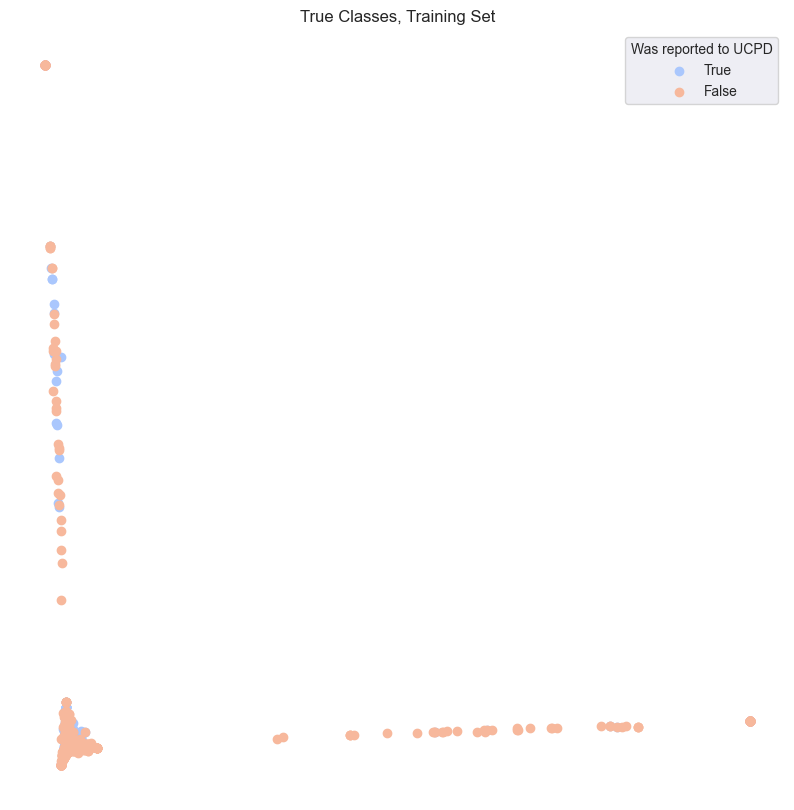

In [363]:
vis_fig, vis_ax = plt.subplots(figsize=(10, 10))
vis_ax.axis("off")
pallet = seaborn.color_palette(palette="coolwarm", n_colors=2)

# Plot UCPD_Reported
a = np.stack(lg_train_df[lg_train_df["UCPD_Reported"]]["pca"])
vis_ax.scatter(a[:, 0], a[:, 1], c=pallet[0], label="True")

# Plot not UCPD_Reported
a = np.stack(lg_train_df[lg_train_df["UCPD_Reported"].eq(False)]["pca"])
vis_ax.scatter(a[:, 0], a[:, 1], c=pallet[1], label="False")

vis_ax.legend(loc="upper right", title="Was reported to UCPD")
plt.title("True Classes, Training Set")
plt.show()

In [364]:
pca_split_stats(lg_test_df, lg_train_df, "pca_reduced_10", "UCPD_Reported", 10)

Linear Regression stats for 10 dimensions
Training:
0.8518766257896693
Testing:
0.8323424494649228


In [365]:
pca_split_stats(lg_test_df, lg_train_df, "pca_reduced_15", "UCPD_Reported", 15)

Linear Regression stats for 15 dimensions
Training:
0.8518766257896693
Testing:
0.821640903686088


In [366]:
pca_split_stats(lg_test_df, lg_train_df, "pca_reduced_25", "UCPD_Reported", 25)

Linear Regression stats for 25 dimensions
Training:
0.8642140468227425
Testing:
0.7853745541022592


In [367]:
pca_split_stats(lg_test_df, lg_train_df, "pca_reduced_50", "UCPD_Reported", 50)

Linear Regression stats for 50 dimensions
Training:
0.8668153102935712
Testing:
0.7868608799048752


In [368]:
pca_split_stats(lg_test_df, lg_train_df, "pca_reduced_50", "UCPD_Reported", 75)

Linear Regression stats for 75 dimensions
Training:
0.8693422519509476
Testing:
0.7859690844233056


In [369]:
pca_split_stats(lg_test_df, lg_train_df, "pca_reduced_100", "UCPD_Reported", 100)

Linear Regression stats for 100 dimensions
Training:
0.8705314009661835
Testing:
0.7856718192627824


In [370]:
pca_split_stats(lg_test_df, lg_train_df, "pca_reduced_200", "UCPD_Reported", 200)

Linear Regression stats for 200 dimensions
Training:
0.8781122259383128
Testing:
0.7862663495838288


F-measure: 0.9648551345791188


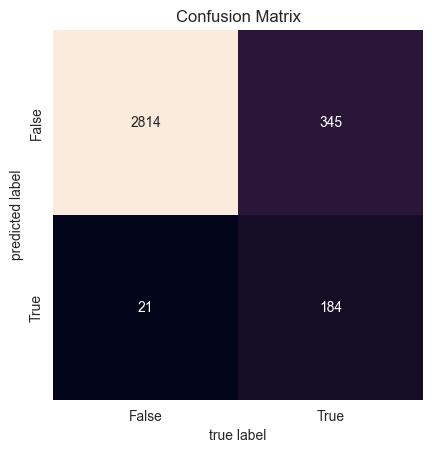

,True Pos,False Pos,True Neg,False Neg
0,2814,21,345,184


,Positive,Error_Rate,AUC,Precision,Average_Precision,Recall
0,False,0.108799,0.670209,0.890788,0.890432,0.992593
1,True,0.108799,0.670209,0.897561,0.414752,0.347826


In [371]:
lg_cm_df, lg_eval_df = logistic_regression_visualizer(lg_test_df)
display(lg_cm_df, lg_eval_df)

## <font color="red">*Exercise 4*</font>

<font color="red">In the cells immediately following, perform decision tree and 
random forest classification (binary, multinomial or continuous) using training, 
testing and extrapolation (un-coded) data from texts and hand-classifications 
associated with your final project. As with ***Exercise 2***, these could be 
crowdsourced codes gathered through Amazon Mechanical Turk last week. Visualize 
the classification of data points. Calculate relevant metrics (e.g., precision, 
recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees 
into a random forest. Visualize the result. How do these classifiers perform? 
What does ensemble learning do?

/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


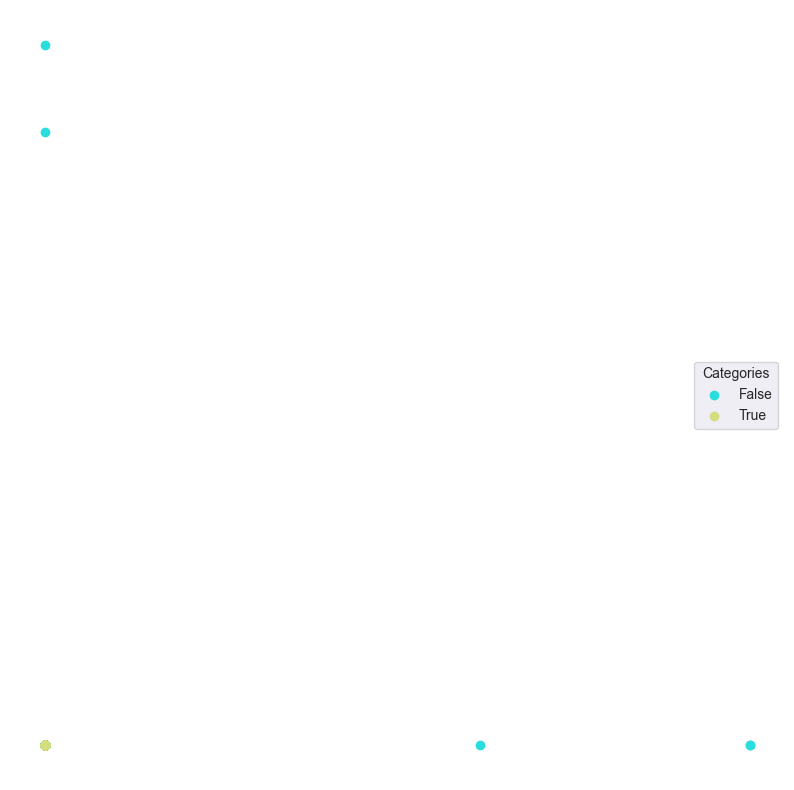

In [9]:
dt_train_df, dt_test_df = sklearn.model_selection.train_test_split(
    ucpd_reports, test_size=TEST_SPLIT
)
dt_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    max_df=100, min_df=2, stop_words="english", norm="l2"
)

# Apply vectors to training and test
dt_vectors_train = dt_vectorizer.fit_transform(dt_train_df["comments"])
dt_train_df["vect"] = [np.array(v).flatten() for v in dt_vectors_train.todense()]

dt_vectors_test = dt_vectorizer.fit_transform(dt_test_df["comments"])
dt_test_df["vect"] = [np.array(v).flatten() for v in dt_vectors_test.todense()]

lucem_illud.plotter(dt_train_df)

In [11]:
clf_dt = sklearn.tree.DecisionTreeClassifier(max_depth=4)
clf_bag = sklearn.ensemble.BaggingClassifier(clf_dt, n_estimators=100, max_samples=0.8)
clf_bag.fit(np.stack(dt_train_df["vect"], axis=0), dt_train_df["category"])

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=4),
                  max_samples=0.8, n_estimators=100)

/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


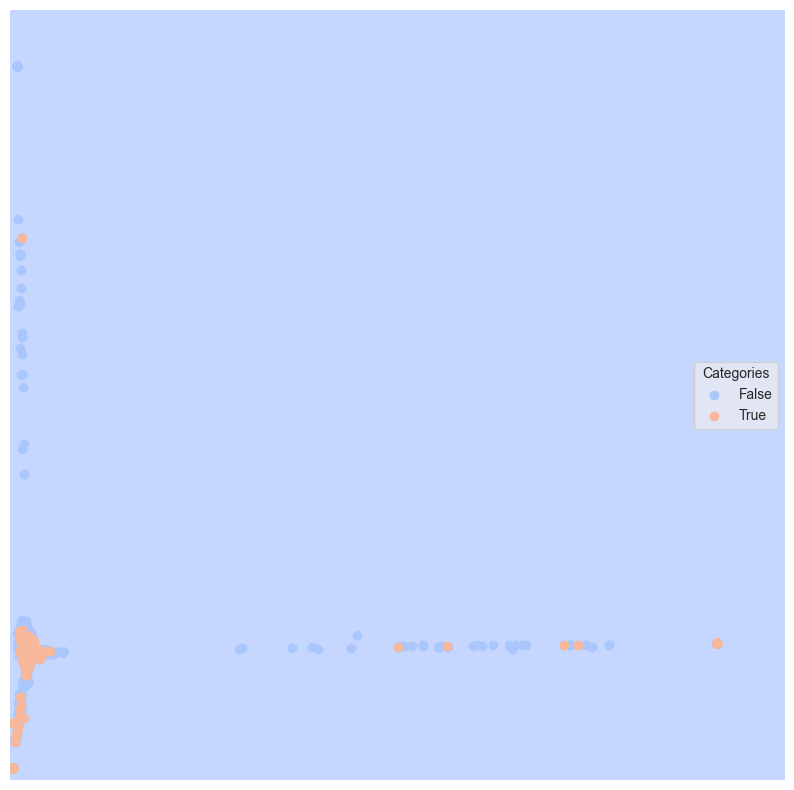

In [12]:
lucem_illud.plotregions(clf_bag, dt_train_df)

In [15]:
# I BELIEVE, I'm supposed to use the test data here, but it consistently
# returned an error message regarding the dimensions. Due to my inability
# to get past that, I used the training DataFrame.
lucem_illud.evaluateClassifier(clf_bag, dt_train_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.139428,0.546723,0.859624,0.859606,0.998509
True,0.139428,0.546723,0.919811,0.225488,0.094937


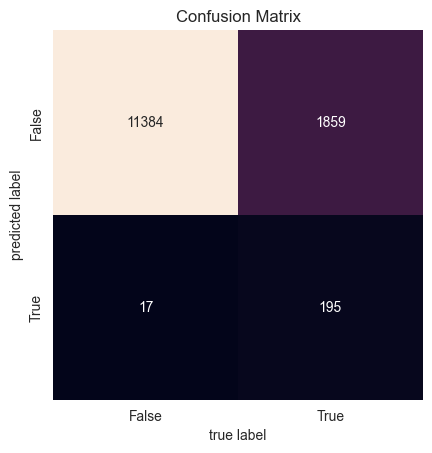

In [16]:
# I BELIEVE, I'm supposed to use the test data here, but it consistently
# returned an error message regarding the dimensions. Due to my inability
# to get past that, I used the training DataFrame.
lucem_illud.plotConfusionMatrix(clf_bag, dt_train_df)

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, perform a neural network 
classification and calculate relevant metrics (e.g., precision, recall, the 
F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, 
logistic and decision-tree approaches?

## <font color="red">*Exercise 7*</font>

<font color="red">In the cells immediately following, use the pipeline functions 
or the word or sentence vector functions (e.g., similarity) to explore the social 
game underlying the production and meaning of texts associated with your final project. 
How does BERT help you gain insight regarding your research question that is similar 
and different from prior methods?